### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import cvxpy as cvx
import warnings
import itertools

from sklearn.covariance import LedoitWolf
from sklearn.decomposition import PCA

### Data import

In [2]:
# Historical price data
historical_price_data = pd.read_csv("..\\Data\\Fidelity\\historical_price.csv")
historical_price_data["time (EST)"] = pd.to_datetime(historical_price_data["time (EST)"])
historical_price_data.set_index("time (EST)", inplace=True)
                                
# Calculate daily returns
price_columns = historical_price_data.columns
daily_returns = historical_price_data[price_columns].pct_change().dropna()

### Portfolio optimization framework introductory model

In [6]:
import warnings
import pandas as pd
import numpy as np
import cvxpy as cvx
from sklearn.covariance import LedoitWolf
import statsmodels.api as sm
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

class Portfolio:
    def __init__(self, tc_penalty, fully_invested, long_only, short_only, market_neutral, position_adv, returns, allocation, starting_weights, expected_holding_t=365, commission=0.0, rebalance_frequency=1,
                 max_w=None, min_w=None, max_variance=None, max_drawdown=None, factor_exposure_matrix=None, max_factor_exposure=None, cov_smoothing=0.99, benchmark="btc",
                 epsilon=0.005):
        self.tc_penalty = tc_penalty # Coefficient that penalizes trading frequency to be optimized later
        self.returns = returns # Returns of the underlying assets
        self.fully_invested = fully_invested # Make the portfolio fully invested (whole capital invested at all times)
        self.long_only = long_only # Make the portfolio go long only (w > 0 for all w)
        self.short_only = short_only # Make the portfolio go short only (w < 0 for all w)
        self.market_neutral = market_neutral # Make the portfolio market-neutral (sum(w) = 0)
        self.position_adv = position_adv # Averarage daily volume constraint for maximizing liquidity (to be implemented later)
        self.max_w = max_w # Maximimum absolute value per weight
        self.allocation = allocation # Initial capital allocation (to be implemented)
        self.expected_holding_t = expected_holding_t # Expected portfolio holding period for statistic annualization
        self.commission = commission # Trading cost heuristic, to be split into commission + slippage later (given slippage model)
        self.weights = starting_weights if starting_weights is not None else pd.Series(1 / returns.shape[1], index=returns.columns)
        self.rebalance_frequency = rebalance_frequency # Minimum rebalancing frequency
        self.turnovers = [] # History of turnovers
        self.max_variance = max_variance # Max variance constraints
        self.max_drawdown = max_drawdown # Max drawdown constraint 
        self.factor_exposure_matrix = factor_exposure_matrix # Matrix of factors
        self.max_factor_exposure = max_factor_exposure # Max exposure per factor
        self.cov_smoothing = cov_smoothing # Cov smoothing/forecast functin (to be implemented, LSTM, GARCH etc.)
        self.min_w = min_w # Minimal absolute value per weight
        self.mean_returns = [] # Mean returns over time to be stored for analysis
        self.benchmark = returns[benchmark] # Benchmark returns
        self.epsilon = epsilon

    def compute_drawdown(self):
        '''
        Compute portfolio's drawdown
        '''
        cumulative_returns = (1 + self.portfolio_returns).cumprod()
        peak = cumulative_returns.cummax()
        drawdown = (cumulative_returns - peak) / peak
        return drawdown

    def sharpe_ratio(self):
        '''
        Compute portfolio's SR
        '''
        return (self.portfolio_returns.mean() / self.portfolio_returns.std()) * np.sqrt(self.expected_holding_t)
    
    def sortino_ratio(self):
        '''
        Compute portfolio's Sortino Ratio
        '''
        downside_std = self.portfolio_returns[self.portfolio_returns < 0].std()
        return (self.portfolio_returns.mean() / downside_std) * np.sqrt(self.expected_holding_t)

    def get_tracking_error(self, w, ideal):
        '''
        First part of the optimization objective function: (w - w_ideal) @ COV @ (w - w_ideal)
        '''
        ideal = ideal.values.reshape(-1, 1)
        tracking_error = cvx.quad_form(w, self.sigma) - 2 * cvx.matmul(ideal.T, self.sigma) @ w - cvx.matmul(ideal.T, self.sigma) @ ideal
        return tracking_error

    def get_tcost(self, w, w_prev):
        '''
        Second part of the objective function. Get total trading cost per single rebalance
        '''
        tcost = self.tc_penalty * cvx.sum(cvx.abs(w - w_prev) * self.commission)
        return tcost

    def optimize_unconstrained(self, ideal):
        '''
        Optimize uncostrained portfolio mean(ret) @ w - w @ COV @ w
        '''
        w = cvx.Variable(self.returns.shape[1])
        tracking_error = self.get_tracking_error(w, ideal)
        objective = cvx.Minimize(tracking_error)
        prob = cvx.Problem(objective)
        prob.solve(solver=cvx.ECOS)
        return w.value  
    
    def validate_weights(self, w):
        '''
        Validate whether the weights satisfy the constraints
        '''
        # Fully invested: sum of absolute weights should be close to 1
        if self.fully_invested and not np.isclose(np.sum(np.abs(w)), 1, atol=self.epsilon):
            return False

        # Long only: all weights should be non-negative
        if self.long_only and np.any(w < -self.epsilon):  # Allow small negative due to numerical issues
            return False

        # Short only: all weights should be non-positive
        if self.short_only and np.any(w > self.epsilon):  # Allow small positive due to numerical issues
            return False

        # Market neutral: sum of weights should be close to 0
        if self.market_neutral and not np.isclose(np.sum(w), 0, atol=self.epsilon):
            return False

        # Max weight constraint
        if self.max_w is not None and np.any(np.abs(w) > self.max_w + self.epsilon):  # Allow small excess due to numerical issues
            return False

        # Min weight constraint
        if self.min_w is not None and np.any(np.abs(w) < self.min_w - self.epsilon):  # Allow small deficit due to numerical issues
            return False

        return True


    def optimize(self, ideal, w_prev):
        '''
        Minimize the objective func. (w - w_ideal) @ COV @ (w - w_ideal) + t_cost, given mean variance ideal weights
        '''
        unconstrained_weights = self.optimize_unconstrained(ideal)
        v = np.sign(unconstrained_weights)
        w = cvx.Variable(self.returns.shape[1])
        u = cvx.Variable(self.returns.shape[1])  # Auxiliary variable for absolute values

        tracking_error = self.get_tracking_error(w, ideal)
        tcost = self.get_tcost(w, w_prev)
        objective = cvx.Minimize(tracking_error + tcost)
        constraints = []

        if self.fully_invested:
            constraints.append(cvx.sum(u) == 1)
            constraints.append(u >= w)
            constraints.append(u >= -w)
        if self.long_only:
            constraints.append(w >= 0)
        if self.short_only:
            constraints.append(w <= 0)
        if self.market_neutral:
            constraints.append(cvx.sum(w) == 0)
        if self.max_w:
            constraints.append(cvx.abs(w) <= self.max_w)
        if self.min_w:
            constraints.append(cvx.multiply(v, w) >= self.min_w)
        if self.max_variance:
            portfolio_variance = cvx.quad_form(w, self.sigma)
            constraints.append(portfolio_variance <= self.max_variance)
        if self.max_drawdown:
            cumulative_returns = cvx.cumsum(w @ self.returns.T)
            max_return = cvx.max(cumulative_returns)
            drawdown = max_return - cumulative_returns
            constraints.append(cvx.max(drawdown) <= self.max_drawdown)
        if self.factor_exposure_matrix is not None and self.max_factor_exposure is not None:
            factor_exposure = cvx.matmul(self.factor_exposure_matrix.T, w)
            constraints.append(cvx.abs(factor_exposure) <= self.max_factor_exposure)

        prob = cvx.Problem(objective, constraints)
        prob.solve(solver=cvx.SCS)
        optimal_weights = pd.Series(w.value, index=ideal.index)
        
        if not self.validate_weights(optimal_weights):
            optimal_weights = w_prev

        return optimal_weights

    def rebalance(self, daily_returns, starting_time, lookback, ideal_weights_function):
        '''
        Rebalancing function. Iterate over the assets over time and create allocation given constraints
        starting_time <- time allocated for the computation of the initial covariance matrix
        ideal_weights_function <- function that computes the ideal weights
        '''
        daily_weights = pd.DataFrame(index=daily_returns.index, columns=daily_returns.columns)
        portfolio_returns = []
        cumulative_returns = 0
        peak = 0
        
        # Initial naively equal weights
        w_prev = pd.Series(1 / len(daily_returns.columns), index=daily_returns.columns)
        
        # Rebalance the portfolio given the lookback parameter for covariance computation
        for i, date in enumerate(daily_returns.index[starting_time:]):
            if i % self.rebalance_frequency == 0:
                signal = daily_returns.loc[:date]
                
                if lookback == "All":
                    sigma_lw = LedoitWolf().fit(signal.fillna(0).values).covariance_
                    self.sigma = sigma_lw
                else:
                    sigma_lw = LedoitWolf().fit(signal.fillna(0).values[-lookback:]).covariance_
                    self.sigma = sigma_lw
                
                mean_returns = signal[-lookback:].mean() if lookback != "All" else signal.mean()
                
                # Compute ideal weights using the passed function
                ideal = ideal_weights_function(signal[-lookback:], sigma_lw)
                optimal_weights = self.optimize(ideal, w_prev)
            else:
                optimal_weights = w_prev
            
            # Make sure that constraints are satisfied, if not don't change weights
            if not self.validate_weights(optimal_weights):
                optimal_weights = w_prev
            
            # Compute next day returns given opt. weights, turnovers, etc.
            self.mean_returns.append(mean_returns)
            daily_weights.loc[date] = optimal_weights
            next_day_returns = daily_returns.shift(-1).loc[date]
            daily_return = (optimal_weights * next_day_returns).sum()
            turnover = np.abs(w_prev - optimal_weights).sum()
            self.turnovers.append(turnover)
            transaction_cost = turnover * self.commission
            daily_return -= transaction_cost
            portfolio_returns.append(daily_return)
            w_prev = optimal_weights

            # Update cumulative returns and peak
            cumulative_returns += daily_return
            peak = max(peak, cumulative_returns)

        self.daily_weights = daily_weights
        self.portfolio_returns = pd.Series(portfolio_returns, index=daily_returns.index[starting_time:])
        self.mean_returns = pd.Series(self.mean_returns, index=daily_returns.index[starting_time:])
        self.turnovers = pd.Series(self.turnovers, index=daily_returns.index[starting_time:])

    def compute_alpha(self):
        '''
        Compute alpha - returns decorrelated from the benchmark
        '''
        if self.portfolio_returns is None:
            raise ValueError("Portfolio returns are not calculated. Please run the rebalance method first.")
        benchmark = self.benchmark[self.portfolio_returns.index]
        excess_portfolio_returns = self.portfolio_returns
        excess_benchmark_returns = benchmark
        X = sm.add_constant(excess_benchmark_returns)
        y = excess_portfolio_returns
        model = sm.OLS(y, X).fit()
        alpha = model.params['const']
        return alpha
    
    def compute_information_ratio(self):
        '''
        Sharpe ratio of the results decorrelated from the benchmark
        '''
        if self.portfolio_returns is None:
            raise ValueError("Portfolio returns are not calculated. Please run the rebalance method first.")
        benchmark = self.benchmark[self.portfolio_returns.index]
        active_returns = self.portfolio_returns - benchmark
        tracking_error = active_returns.std()
        information_ratio = active_returns.mean() / tracking_error * np.sqrt(self.expected_holding_t)
        return information_ratio
    
    def compute_var(self, alpha=0.05):
        return np.percentile(self.portfolio_returns, 100 * alpha)
    
    def compute_cvar(self, alpha=0.05):
        var = self.compute_var(alpha)
        cvar = self.portfolio_returns[self.portfolio_returns <= var].mean()
        return cvar
    
    def plot(self):
        '''
        Plot cumulative returns of the portfolio, moving drawdown and evolution of the weights over time
        '''
        # Create a figure with subplots
        fig, ax = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

        # Plot cumulative portfolio returns
        ax[0].plot(self.portfolio_returns.index, self.portfolio_returns.cumsum(), label='Cumulative Returns')
        ax[0].set_title('Cumulative Portfolio Returns')
        ax[0].set_ylabel('Cumulative Returns')
        ax[0].legend()
        ax[0].grid(True)

        # Plot daily weights
        self.daily_weights.plot(ax=ax[1], legend=True)
        ax[1].set_title('Daily Portfolio Weights')
        ax[1].set_ylabel('Weights')
        ax[1].grid(True)

        # Plot drawdown
        ax[2].plot(self.portfolio_returns.index, self.compute_drawdown(), label='Drawdown')
        ax[2].set_title('Portfolio Drawdown')
        ax[2].set_ylabel('Drawdown')
        ax[2].set_xlabel('Date')
        ax[2].legend()
        ax[2].grid(True)

        # Adjust layout
        plt.tight_layout()
        plt.show()


### Simple use case

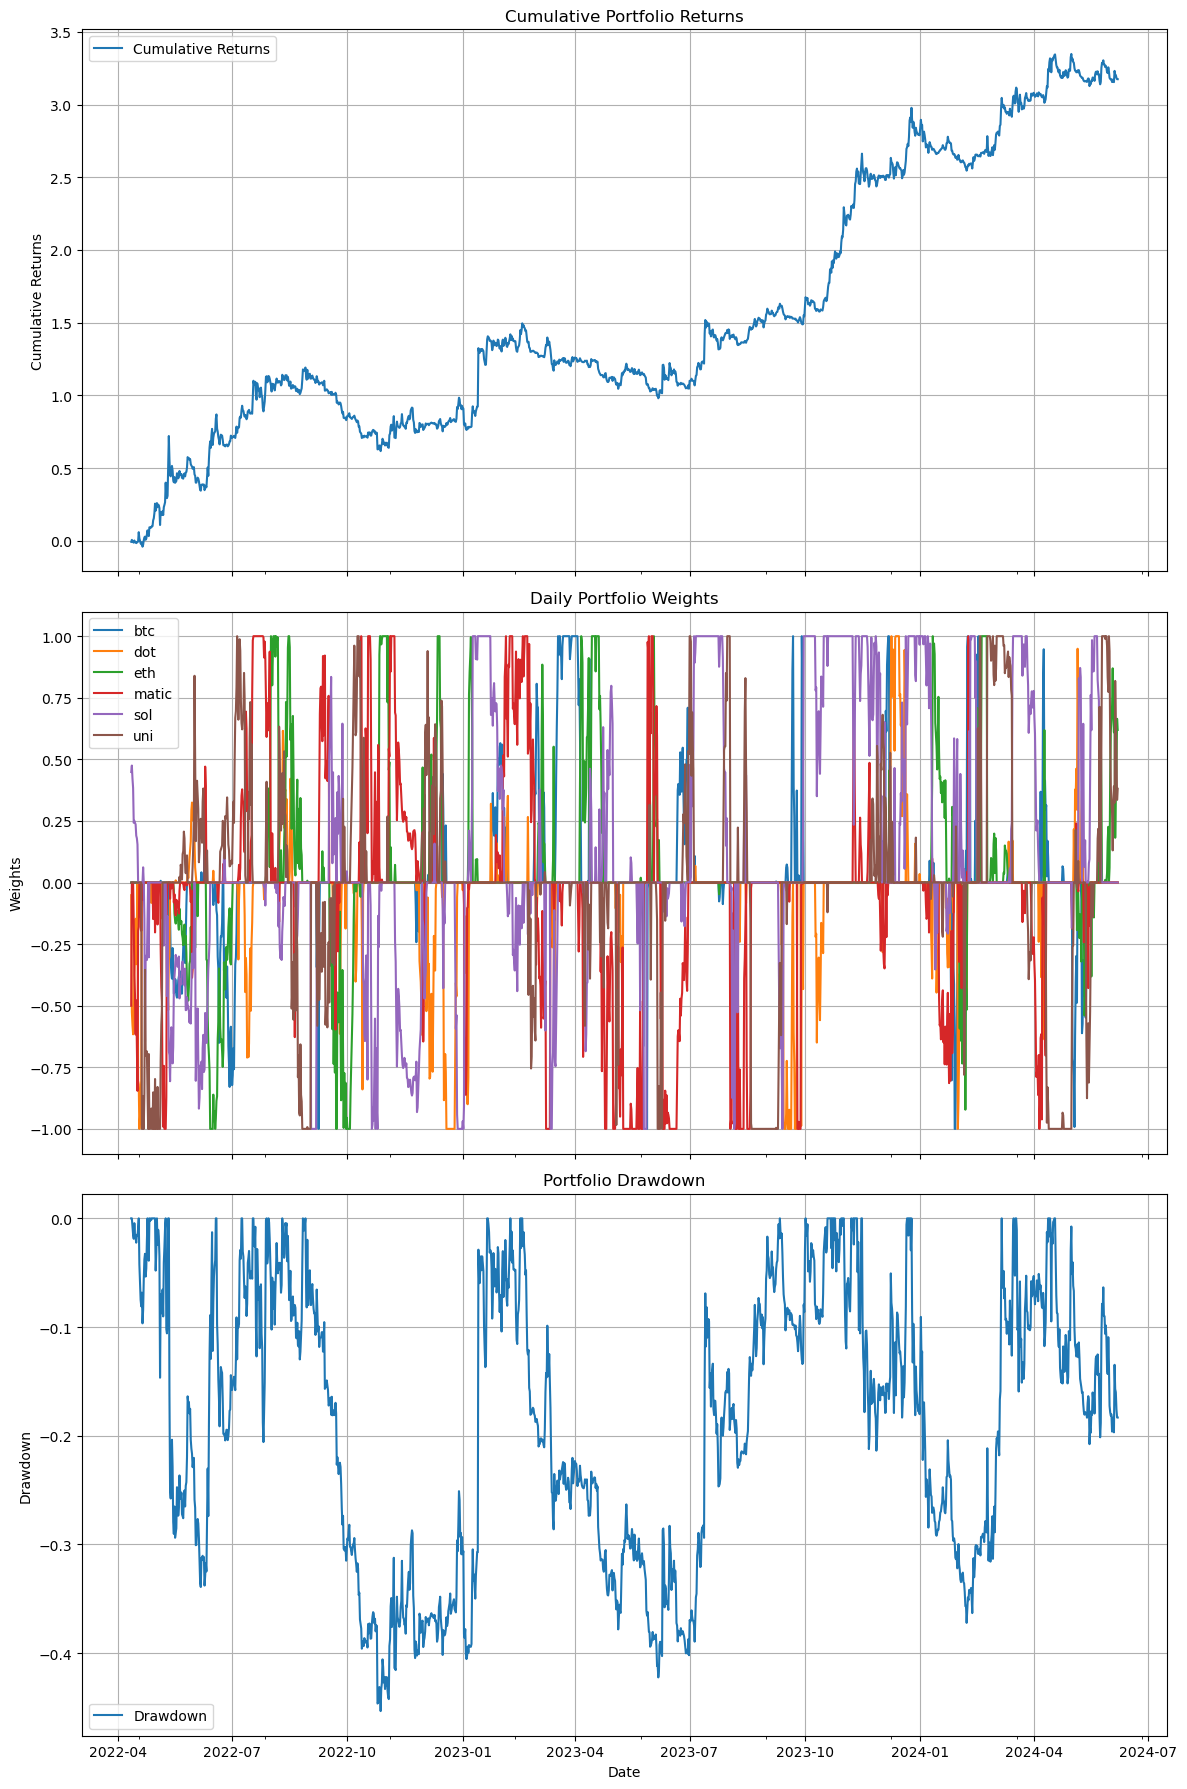

Optimal Weights (last day): btc      0.000001
dot      0.000001
eth      0.619338
matic    0.000001
sol           0.0
uni      0.380694
Name: 2024-06-06 15:00:00, dtype: object
Sharpe Ratio: 1.1695106757258598
Sortino Ratio: 1.9419902774752926
VaR: -0.04254897234521669
CVaR: -0.06396517066242507


In [8]:
def mean_variance(signal, sigma_lw):
    """
    Example reversal strategy: allocate more to assets that have performed worse recently.
    """
    mean_returns = signal.mean()
    w = pd.Series(np.linalg.inv(sigma_lw) @ mean_returns, index=daily_returns.columns)
    return w

def reversal_strategy(signal, sigma_lw):
    """
    Reversal strategy using rank transform: allocate more to assets that have performed worse recently.
    """
    ranks = signal.rank(axis=1, method='min', ascending=False).mean()
    inv_ranks = 1 / ranks
    mean_returns = signal.mean()
    cov_inv = np.linalg.inv(sigma_lw)
    raw_weights = cov_inv @ (mean_returns * inv_ranks)
    normalized_weights = raw_weights / np.sum(raw_weights)
    weights_series = pd.Series(raw_weights, index=signal.columns, name='Weights')
    return weights_series

# Create Portfolio instance
portfolio = Portfolio(
                tc_penalty=1/1000,
                fully_invested=True,
                long_only=False,
                short_only=False,
                market_neutral=False,
                position_adv=None,
                returns=daily_returns,
                allocation=None,
                starting_weights=None,
                expected_holding_t=365,
                commission=0.0001,
                rebalance_frequency=1,
                max_w=1,
                min_w=None,
                max_variance=None,
                max_drawdown=None,
                factor_exposure_matrix=None,
                max_factor_exposure=None,
                cov_smoothing=0.99,
                benchmark="btc",
                epsilon=0.01
            )

# Rebalance the portfolio using the reversal strategy
portfolio.rebalance(daily_returns=daily_returns, starting_time=200, lookback=40, ideal_weights_function=reversal_strategy)

# Plot results
portfolio.plot()

# Calculate the metrics
sharpe_ratio = portfolio.sharpe_ratio()
sortino_ratio = portfolio.sortino_ratio()
var = portfolio.compute_var()
cvar = portfolio.compute_cvar()

# Output the results
print("Optimal Weights (last day):", portfolio.daily_weights.iloc[-1])
print("Sharpe Ratio:", sharpe_ratio)
print("Sortino Ratio:", sortino_ratio)
print("VaR:", var)
print("CVaR:", cvar)

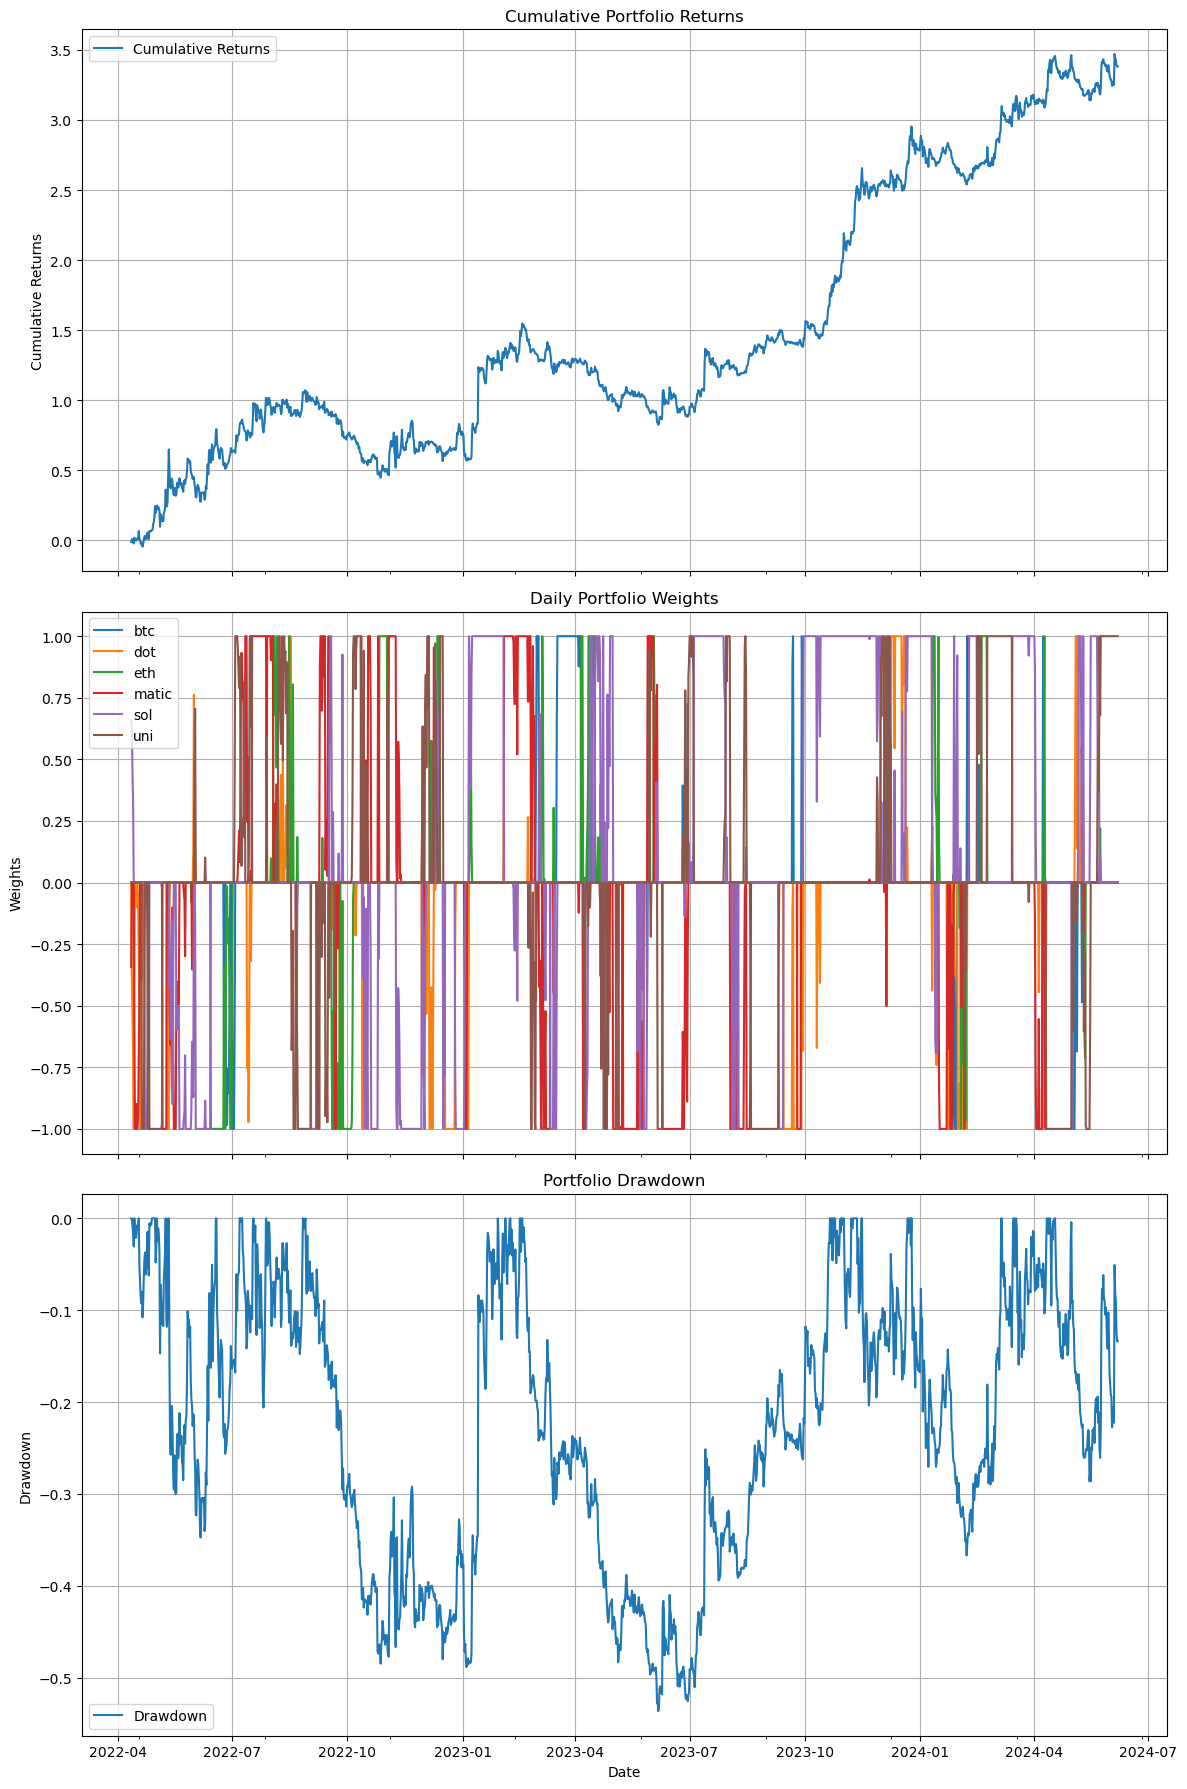

Optimal Weights (last day): btc      0.000001
dot      0.000002
eth      0.000002
matic    0.000001
sol      0.000001
uni      1.000014
Name: 2024-06-06 15:00:00, dtype: object
Sharpe Ratio: 1.1049442631574602
Sortino Ratio: 1.876161063913296
VaR: -0.04850837078689942
CVaR: -0.07138310771471575


In [9]:
# Create Portfolio instance
portfolio = Portfolio(
                tc_penalty=1/1000,
                fully_invested=True,
                long_only=False,
                short_only=False,
                market_neutral=False,
                position_adv=None,
                returns=daily_returns,
                allocation=None,
                starting_weights=None,
                expected_holding_t=365,
                commission=0.0001,
                rebalance_frequency=1,
                max_w=1,
                min_w=None,
                max_variance=None,
                max_drawdown=None,
                factor_exposure_matrix=None,
                max_factor_exposure=None,
                cov_smoothing=0.99,
                benchmark="btc",
                epsilon=0.01
            )

# Rebalance the portfolio using the reversal strategy
portfolio.rebalance(daily_returns=daily_returns, starting_time=200, lookback=40, ideal_weights_function=mean_variance)

# Plot results
portfolio.plot()

# Calculate the metrics
sharpe_ratio = portfolio.sharpe_ratio()
sortino_ratio = portfolio.sortino_ratio()
var = portfolio.compute_var()
cvar = portfolio.compute_cvar()

# Output the results
print("Optimal Weights (last day):", portfolio.daily_weights.iloc[-1])
print("Sharpe Ratio:", sharpe_ratio)
print("Sortino Ratio:", sortino_ratio)
print("VaR:", var)
print("CVaR:", cvar)

### Parameter optimization given portfolio type

In [67]:
def optimize_portfolio(daily_returns, tc_penalty_range, rebalance_frequency_range, lookback_range, ideal_fun, starting_time, **portfolio_params):
    best_sharpe_ratio = -np.inf
    best_tc_penalty = None
    best_rebalance_frequency = None
    best_lookback = None
    best_portfolio = None
    results = []

    for tc_penalty, rebalance_frequency, lookback in itertools.product(tc_penalty_range, rebalance_frequency_range, lookback_range):
        portfolio_params['tc_penalty'] = tc_penalty
        portfolio_params['rebalance_frequency'] = rebalance_frequency

        # Create and run the portfolio optimization on the training set
        portfolio = Portfolio(**portfolio_params)
        portfolio.rebalance(daily_returns, lookback=lookback, starting_time=starting_time, ideal_weights_function=ideal_fun)

        # Calculate Sharpe ratio on the training set
        sharpe_ratio = portfolio.sharpe_ratio()
        
        # Store results
        results.append({
            'tc_penalty': tc_penalty,
            'rebalance_frequency': rebalance_frequency,
            'sharpe_ratio': sharpe_ratio,
            'lookback': lookback
        })

        # Check if this is the best Sharpe ratio
        if sharpe_ratio > best_sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            best_tc_penalty = tc_penalty
            best_rebalance_frequency = rebalance_frequency
            best_lookback = lookback
            best_portfolio = portfolio

    return best_tc_penalty, best_rebalance_frequency, best_lookback, results, best_portfolio

# Split the daily returns into train and test sets
split_ratio = 0.7
split_index = int(len(daily_returns) * split_ratio)
train_returns = daily_returns[:split_index]
test_returns = daily_returns[split_index:]

# Define ranges for optimization - simple example to minimize runtime
tc_penalty_range = [1/100, 1/1000]
lookback_range = [5, 10, 15, 30, 50, 100, 150, 200]
rebalance_frequency_range = [1, 3, 6, 10]

# Example portfolio constraints
portfolio_params = {
    'fully_invested': True,
    'long_only': False,
    'short_only': False,
    'market_neutral': False,
    'position_adv': None,
    'allocation': None,
    'returns': train_returns,
    'starting_weights': None,
    'commission': 2e-4,
    'max_w': 0.5,
    'min_w': 0.05,
    'max_variance': None,
    'factor_exposure_matrix': None,
    'max_factor_exposure': None,
    'cov_smoothing': 0.99
}

# Run the optimization on the training set
best_tc_penalty, best_rebalance_frequency, best_lookback, results, best_portfolio = optimize_portfolio(
    train_returns, tc_penalty_range, rebalance_frequency_range, lookback_range, ideal_fun=mean_variance, starting_time=200, **portfolio_params
)

# Output the best parameters
print(f"Best TC Penalty: {best_tc_penalty}")
print(f"Best Rebalance Frequency: {best_rebalance_frequency}")
print(f"Best Lookback: {best_lookback}")

# Output the results
results_df = pd.DataFrame(results)
print(results_df)

# Update the portfolio parameters for the best tc_penalty and best_rebalance_frequency
portfolio_params['tc_penalty'] = best_tc_penalty
portfolio_params['rebalance_frequency'] = best_rebalance_frequency
portfolio_params['returns'] = test_returns

# Evaluate the best portfolio on the test set
best_portfolio_test = Portfolio(**portfolio_params)
best_portfolio_test.rebalance(test_returns, lookback=best_lookback, starting_time=200, ideal_weights_function=reversal_strategy)

# Check if portfolio returns are empty and handle the case
if best_portfolio_test.portfolio_returns.empty:
    print("No returns generated during the test period. Please check the rebalancing logic and data.")
else:
    # Compute additional metrics using the best portfolio on the test set
    sharpe_ratio = best_portfolio_test.sharpe_ratio()
    sortino_ratio = best_portfolio_test.sortino_ratio()
    var = best_portfolio_test.compute_var()
    cvar = best_portfolio_test.compute_cvar()

    # Output the additional metrics
    print("Evaluation on test set:")
    print(f"Sharpe Ratio: {sharpe_ratio}")
    print(f"Sortino Ratio: {sortino_ratio}")
    print(f"Value at Risk (VaR): {var}")
    print(f"Conditional Value at Risk (CVaR): {cvar}")

KeyboardInterrupt: 